# COVID-19 Spread Assessment in New York

Importing required libraries:

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [44]:
import seaborn as sns
%matplotlib inline

In [48]:
from scipy import stats

## __Dataset 1: COVID-19 data__

Read CSV data of COVID-19 cases and deaths in each New York county into a pandas dataframe.

In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")

In [3]:
df.dtypes

date       object
county     object
state      object
fips      float64
cases       int64
deaths      int64
dtype: object

Since, the data consists of all the dates since the 1st patient was diagnosed in the USA, so focusing the analysis to the cummulative cases on 9th April 2020 in the state of New York.

In [4]:
df_Latest=df[(df.date=='2020-04-09') & (df.state=='New York')].reset_index(drop=True)

In [5]:
df_Latest.head()

,date,county,state,fips,cases,deaths
0,2020-04-09,Albany,New York,36001.0,379,12
1,2020-04-09,Allegany,New York,36003.0,22,0
2,2020-04-09,Broome,New York,36007.0,105,6
3,2020-04-09,Cattaraugus,New York,36009.0,17,0
4,2020-04-09,Cayuga,New York,36011.0,16,1


In [6]:
df_Latest.shape[0]

58

The data contains reported cases and deaths from 58 counties.

### __Visualizing the most affected counties by the COVID-19__

In [7]:
dfViz1=df_Latest.sort_values(['cases'], ascending=False, axis=0)

# get the top 5 entries
df_top5 = dfViz1.head(10)
df_top5=df_top5[['county','cases']]

# transpose the dataframe
#df_top5= df_top5.transpose() 

df_top5.head()

,county,cases
28,New York City,87028
27,Nassau,20140
47,Suffolk,17413
55,Westchester,17004
39,Rockland,6665


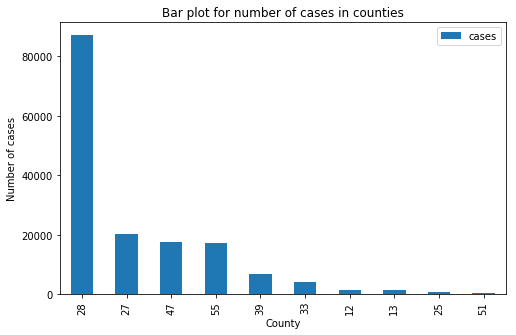

In [8]:
#df_top5 = df_top5.set_index('county')
# let's change the index values of df_top5 to type integer for plotting
df_top5.plot(kind='bar', 
             figsize=(8, 5)# pass a tuple (x, y) size
             )

plt.title('Bar plot for number of cases in counties')
plt.ylabel('Number of cases')
plt.xlabel('County')

plt.show()

## __Dataset 2: 2020 Population data of New York__

Next, reading in population data of New York into a dataframe, and selecting the population column along with respective county.

In [9]:
# The code was removed by Watson Studio for sharing.

,Name,2020 Population,Growth Since 2010
0,Kings County,2582830,0.0291
1,Queens County,2278906,0.0198
2,New York County,1628701,0.0251
3,Suffolk County,1481093,-0.0089
4,Bronx County,1432132,0.0323


In [10]:
df_data_0.dtypes

Name                   object
2020 Population         int64
Growth Since 2010     float64
dtype: object

## __Data cleaning and transformation__

Selecting only the first 2 columns..

In [11]:
dfPopNY=df_data_0.iloc[:, 0:2]

Renaming the columns and stripping the word 'County' from each county name.

In [12]:
dfPopNY.rename(columns={"Name ":"county",'2020 Population ':'2020 Population'},inplace=True)

In [13]:
dfPopNY['county']= dfPopNY['county'].map(lambda x: x.rstrip(' County'))

Checking the spellings of counties in both dataframes:

In [14]:
print(sorted(dfPopNY.county))

['Alba', 'Allega', 'Bronx', 'Broome', 'Cattaraugus', 'Cayuga', 'Chautauqua', 'Chemung', 'Chenang', 'Cli', 'Columbia', 'Cortland', 'Delaware', 'Dutchess', 'Erie', 'Essex', 'Frankli', 'Ful', 'Genesee', 'Greene', 'Hamil', 'Herkimer', 'Jeffers', 'Kings', 'Lewis', 'Livings', 'Madis', 'Monroe', 'Montgomer', 'Nassa', 'New York', 'Niagara', 'Oneida', 'Onondaga', 'Ontari', 'Orange', 'Orleans', 'Osweg', 'Otseg', 'Putnam', 'Queens', 'Rensselaer', 'Richmond', 'Rockland', 'Saratoga', 'Schenectad', 'Schoharie', 'Schuyler', 'Seneca', 'St. Lawrence', 'Steube', 'Suffolk', 'Sulliva', 'Tioga', 'Tompkins', 'Ulster', 'Warre', 'Washing', 'Wayne', 'Westchester', 'Wyoming', 'Yates']


In [16]:
print(sorted(df_Latest.county))

['Albany', 'Allegany', 'Broome', 'Cattaraugus', 'Cayuga', 'Chautauqua', 'Chemung', 'Chenango', 'Clinton', 'Columbia', 'Cortland', 'Delaware', 'Dutchess', 'Erie', 'Essex', 'Franklin', 'Fulton', 'Genesee', 'Greene', 'Hamilton', 'Herkimer', 'Jefferson', 'Lewis', 'Livingston', 'Madison', 'Monroe', 'Montgomery', 'Nassau', 'New York City', 'Niagara', 'Oneida', 'Onondaga', 'Ontario', 'Orange', 'Orleans', 'Oswego', 'Otsego', 'Putnam', 'Rensselaer', 'Rockland', 'Saratoga', 'Schenectady', 'Schoharie', 'Schuyler', 'Seneca', 'St. Lawrence', 'Steuben', 'Suffolk', 'Sullivan', 'Tioga', 'Tompkins', 'Ulster', 'Warren', 'Washington', 'Wayne', 'Westchester', 'Wyoming', 'Yates']


Replacing the county spellings in dfPopNY to match those of df_Latest

In [17]:
dfPopNY["county"].replace({"Alba": "Albany", "Allega": "Allegany"}, inplace=True)

In [18]:
dfPopNY["county"].replace({"Chenang": "Chenango", "Cli": "Clinton",'Frankli':'Franklin','Ful':'Fulton','Hamil':'Hamilton','Jeffers':'Jefferson','Livings':'Livingston',"Madis":'Madison'}, inplace=True)

In [19]:
dfPopNY["county"].replace({"Montgomer": "Montgomery", "Nassa": "Nassau",'New York':'New York City','Ontari':'Ontario','Osweg':'Oswego','Otseg':'Otsego','Schenectad':'Schenectady',"Steube":'Steuben','Sulliva':'Sullivan','Warre':'Warren','Washing':'Washington'}, inplace=True)

In [20]:
dfPopNY.head()

,county,2020 Population
0,Kings,2582830
1,Queens,2278906
2,New York City,1628701
3,Suffolk,1481093
4,Bronx,1432132


The above 2 dataframes are joined with key on county

In [22]:
df_NYCoord = pd.merge(df_Latest, dfPopNY, how= 'inner',on='county')

In [23]:
df_NYCoord.columns

Index(['date', 'county', 'state', 'fips', 'cases', 'deaths',
       '2020 Population'],
      dtype='object')

Transforming number of cases and deaths as percentage of the cases and deaths from population: 

In [24]:
df_NYCoord['deaths']=df_NYCoord['deaths'].div(df_NYCoord['cases'])*100

In [25]:
df_NYCoord['cases']=df_NYCoord['cases'].div(df_NYCoord['2020 Population'])*100

In [26]:
df_NYCoord.head()

,date,county,state,fips,cases,deaths,2020 Population
0,2020-04-09,Albany,New York,36001.0,0.123406,3.166227,307117
1,2020-04-09,Allegany,New York,36003.0,0.047383,0.000000,46430
2,2020-04-09,Broome,New York,36007.0,0.054785,5.714286,191659
3,2020-04-09,Cattaraugus,New York,36009.0,0.022124,0.000000,76840
4,2020-04-09,Cayuga,New York,36011.0,0.020740,6.250000,77145


## __FourSquare API__

Initiating foursquare credential variables.

In [27]:
CLIENT_ID = '0J0TRFUIL2P1HXHXOTGOELH4CVTZTQAQH4R4CARJKODDMXNP' # your Foursquare ID
CLIENT_SECRET = '3EC3NGHVOFUSS4XHHQDTPC3ADJ1PPQG1DUWMNM0OLVZ0GHCM' # your Foursquare Secret
VERSION = '20200412' # Foursquare API version

Defining LIMIT and categoryId of venue categories of travel, food, and nightlife.

In [28]:
categoryIdFood='4d4b7105d754a06374d81259'
categoryIdTravel='4d4b7105d754a06379d81259'
categoryIdNightLife='4d4b7105d754a06376d81259'

__Borrowing the function from the lab, and changing the url to endpoint 'search' with categoryId and intent='browse'. In addition, here I am not giving the location coordinates. I am using the 'near' parameter to specify the name of county.__

Defining 2 functions:
1. Travel and night life venues
2. Food venues

__Travel venues function:__

In [29]:
LIMIT=100
def getNearbyVenues(names, cases, deaths, radius= 750, intent ='browse'):
    
    venues_list=[]
    for  name, case, death in zip(names, cases, deaths):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&near={}&intent={}&radius={}&categoryId={},{}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            name+', NY',
            intent,
            radius,
            categoryIdTravel,
            categoryIdNightLife,
            LIMIT)  
        # make the GET request
        results = requests.get(url).json()['response']['venues']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            case,
            death,
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name'])for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['County',
                             'Cases',
                             'Deaths',
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

__Food venues function:__

In [30]:
LIMIT=100
def getNearbyVenuesF(names, cases, deaths, radius= 750, intent ='browse'):
    
    venues_list=[]
    for  name, case, death in zip(names, cases, deaths):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&near={}&intent={}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            name+', NY',
            intent,
            radius,
            categoryIdFood,
            LIMIT)  
        # make the GET request
        results = requests.get(url).json()['response']['venues']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            case,
            death,
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name'])for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['County',
                             'Cases',
                             'Deaths',
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

Using the functions to get 2 dataframe populated with various venues:

__Travel, NightLife venues:__

In [51]:

newyork_venues_TravelNL = getNearbyVenues(names=df_NYCoord['county'],cases=df_NYCoord['cases'],deaths=df_NYCoord['deaths'])

Albany
Allegany
Broome
Cattaraugus
Cayuga
Chautauqua
Chemung
Chenango
Clinton
Columbia
Cortland
Delaware
Dutchess
Erie
Essex
Franklin
Fulton
Genesee
Greene
Hamilton
Herkimer
Jefferson
Lewis
Livingston
Madison
Monroe
Montgomery
Nassau
New York City
Niagara
Oneida
Onondaga
Ontario
Orange
Orleans
Oswego
Otsego
Putnam
Rensselaer
Rockland
Saratoga
Schenectady
Schoharie
Schuyler
Seneca
St. Lawrence
Steuben
Suffolk
Sullivan
Tioga
Tompkins
Ulster
Warren
Washington
Wayne
Westchester
Wyoming
Yates


__Food venues:__

In [32]:

newyork_venues_Food = getNearbyVenuesF(names=df_NYCoord['county'],cases=df_NYCoord['cases'],deaths=df_NYCoord['deaths'])

Albany
Allegany
Broome
Cattaraugus
Cayuga
Chautauqua
Chemung
Chenango
Clinton
Columbia
Cortland
Delaware
Dutchess
Erie
Essex
Franklin
Fulton
Genesee
Greene
Hamilton
Herkimer
Jefferson
Lewis
Livingston
Madison
Monroe
Montgomery
Nassau
New York City
Niagara
Oneida
Onondaga
Ontario
Orange
Orleans
Oswego
Otsego
Putnam
Rensselaer
Rockland
Saratoga
Schenectady
Schoharie
Schuyler
Seneca
St. Lawrence
Steuben
Suffolk
Sullivan
Tioga
Tompkins
Ulster
Warren
Washington
Wayne
Westchester
Wyoming
Yates


In [33]:
print(newyork_venues_TravelNL.shape)
newyork_venues_TravelNL.head()

(518, 7)


,County,Cases,Deaths,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Albany,0.123406,3.166227,C.H. Evans Brewing Co. at the Albany Pump Station,42.654076,-73.747658,Brewery
1,Albany,0.123406,3.166227,Elk Street Parking Lot,42.654943,-73.758392,Road
2,Albany,0.123406,3.166227,New Madison Grille,42.650193,-73.763589,Pub
3,Albany,0.123406,3.166227,State St. & Eagle St. Bus Stop,42.651538,-73.755018,Bus Stop
4,Albany,0.123406,3.166227,Hilton,42.650647,-73.753123,Hotel


In [34]:
print(newyork_venues_Food.shape)
newyork_venues_Food.head()

(660, 7)


,County,Cases,Deaths,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Albany,0.123406,3.166227,C.H. Evans Brewing Co. at the Albany Pump Station,42.654076,-73.747658,Brewery
1,Albany,0.123406,3.166227,Mugshots,42.651457,-73.749955,Coffee Shop
2,Albany,0.123406,3.166227,Iron Gate Cafe,42.655974,-73.762504,Café
3,Albany,0.123406,3.166227,The Hollow,42.652299,-73.750831,American Restaurant
4,Albany,0.123406,3.166227,Dove + Deer,42.654634,-73.761936,Restaurant


In [37]:
print('There are {} uniques categories in Travel and Night life venues.'.format(len(newyork_venues_TravelNL['Venue Category'].unique())))

There are 63 uniques categories in Travel and Night life venues.


In [38]:
print('There are {} uniques categories in food venues.'.format(len(newyork_venues_Food['Venue Category'].unique())))

There are 74 uniques categories in food venues.


__Using one hot encoding to transform the dataframes:__

In [40]:
# one hot encoding
NY_onehot_tavNL= pd.get_dummies(newyork_venues_TravelNL[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NY_onehot_tavNL['County'] = newyork_venues_TravelNL['County']
NY_onehot_tavNL['Cases'] = newyork_venues_TravelNL['Cases']
NY_onehot_tavNL['Deaths'] = newyork_venues_TravelNL['Deaths']

# move neighborhood column to the first column
fixed_columns = list(NY_onehot_tavNL.columns[-3:]) + list(NY_onehot_tavNL.columns[:-3])
NY_onehot_tavNL = NY_onehot_tavNL[fixed_columns]
NY_onehot_tavNL.head()

,County,Cases,Deaths,American Restaurant,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Bike Rental / Bike Share,Boarding House,Boat or Ferry,Brewery,Building,Burrito Place,Bus Line,Bus Station,Bus Stop,Cajun / Creole Restaurant,Cocktail Bar,Dive Bar,Event Space,Gastropub,Gay Bar,General Travel,History Museum,Hookah Bar,Hotel,Hotel Bar,Intersection,Karaoke Bar,Liquor Store,Lounge,Metro Station,Motel,Moving Target,New American Restaurant,Nightclub,Nightlife Spot,Other Nightlife,Piano Bar,Pier,Plane,Platform,Pub,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Road,Speakeasy,Sports Bar,Steakhouse,Strip Club,Taxi,Tiki Bar,Tour Provider,Tourist Information Center,Train,Train Station,Transportation Service,Travel & Transport,Travel Agency,Travel Lounge,Tunnel,Wine Bar
0,Albany,0.123406,3.166227,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Albany,0.123406,3.166227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Albany,0.123406,3.166227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Albany,0.123406,3.166227,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Albany,0.123406,3.166227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
# one hot encoding
NY_onehot_food= pd.get_dummies(newyork_venues_Food[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NY_onehot_food['County'] = newyork_venues_Food['County']
NY_onehot_food['Cases'] = newyork_venues_Food['Cases']
NY_onehot_food['Deaths'] = newyork_venues_Food['Deaths']

# move neighborhood column to the first column
fixed_columns = list(NY_onehot_food.columns[-3:]) + list(NY_onehot_food.columns[:-3])
NY_onehot_food = NY_onehot_food[fixed_columns]
NY_onehot_food.head()

,County,Cases,Deaths,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Bistro,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Convenience Store,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Donut Shop,Farmers Market,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gas Station,Gastropub,Gourmet Shop,Greek Restaurant,Gym / Fitness Center,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Kosher Restaurant,Lounge,Mac & Cheese Joint,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Pizza Place,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Albany,0.123406,3.166227,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Albany,0.123406,3.166227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Albany,0.123406,3.166227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Albany,0.123406,3.166227,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Albany,0.123406,3.166227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### __Grouping the dataframes by County, cases, and deaths:__

In [41]:
NY_TrvNL_grouped = NY_onehot_tavNL.groupby(['County','Cases','Deaths']).sum().reset_index()
NY_TrvNL_grouped

,County,Cases,Deaths,American Restaurant,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Bike Rental / Bike Share,Boarding House,Boat or Ferry,Brewery,Building,Burrito Place,Bus Line,Bus Station,Bus Stop,Cajun / Creole Restaurant,Cocktail Bar,Dive Bar,Event Space,Gastropub,Gay Bar,General Travel,History Museum,Hookah Bar,Hotel,Hotel Bar,Intersection,Karaoke Bar,Liquor Store,Lounge,Metro Station,Motel,Moving Target,New American Restaurant,Nightclub,Nightlife Spot,Other Nightlife,Piano Bar,Pier,Plane,Platform,Pub,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Road,Speakeasy,Sports Bar,Steakhouse,Strip Club,Taxi,Tiki Bar,Tour Provider,Tourist Information Center,Train,Train Station,Transportation Service,Travel & Transport,Travel Agency,Travel Lounge,Tunnel,Wine Bar
0,Albany,0.123406,3.166227,1,5,0,0,0,0,0,0,1,0,0,3,3,3,1,1,0,0,1,0,2,0,0,6,2,0,0,0,2,0,0,1,0,3,0,1,0,0,0,0,7,1,0,0,0,1,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
1,Allegany,0.047383,0.000000,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,Broome,0.054785,5.714286,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Cayuga,0.020740,6.250000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Chautauqua,0.014069,5.555556,0,0,3,0,0,1,4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,2,0,0,0,1,0,0,0,0
5,Chemung,0.070026,3.389831,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,Clinton,0.049569,0.000000,0,2,4,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,Cortland,0.033457,0.000000,1,12,2,0,3,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,3,1,0,0,0,0,2,0,0,4,0,2,1,5,0,0,0,0,2,0,1,0,0,0,3,1,0,0,3,0,0,0,0,0,0,0,0,1,0,0,1
8,Essex,0.021448,0.000000,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Franklin,0.021872,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [42]:
NY_Food_grouped = NY_onehot_food.groupby(['County','Cases','Deaths']).sum().reset_index()


,County,Cases,Deaths,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Bistro,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Convenience Store,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Donut Shop,Farmers Market,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gas Station,Gastropub,Gourmet Shop,Greek Restaurant,Gym / Fitness Center,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Kosher Restaurant,Lounge,Mac & Cheese Joint,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Pizza Place,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Albany,0.123406,3.166227,4,0,0,0,0,0,0,0,1,0,1,0,0,0,0,6,1,1,0,3,0,0,5,1,0,2,0,0,4,0,2,1,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,2,0,0,1,4,1,3,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0
1,Allegany,0.047383,0.000000,2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Cattaraugus,0.022124,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Chautauqua,0.014069,5.555556,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Clinton,0.049569,0.000000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,3,0,0,0,1,0,1,0,1,2,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,3,0,3,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0
5,Cortland,0.033457,0.000000,4,0,1,2,1,2,2,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,2,2,3,0,1,1,7,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,9,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Erie,0.148089,3.377386,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Essex,0.021448,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,Franklin,0.021872,0.000000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Fulton,0.027990,0.000000,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,1,0,0,0,2,0,3,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0


## __Data Exploratory Analysis__

__Visualizing scatter plots of number of different food venue categories with number of  deaths in each county:__

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


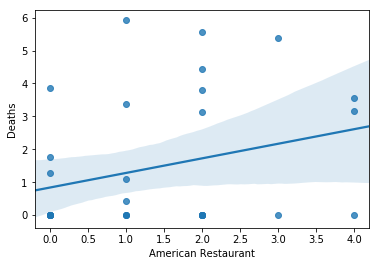

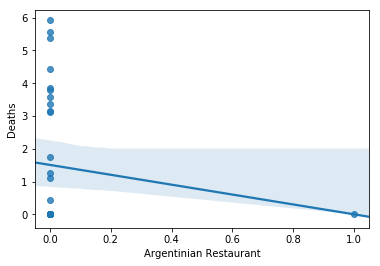

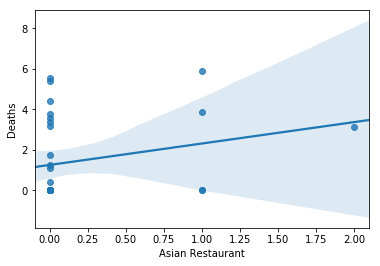

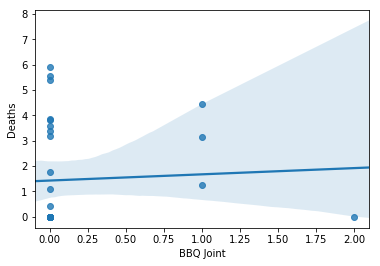

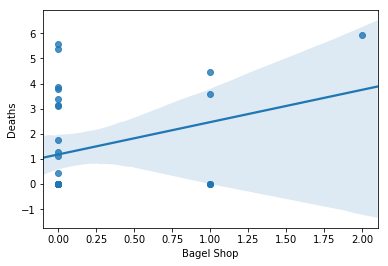

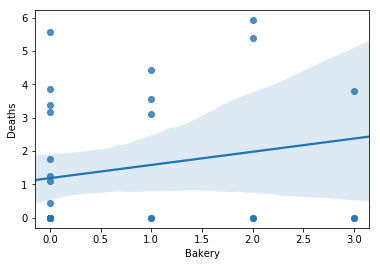

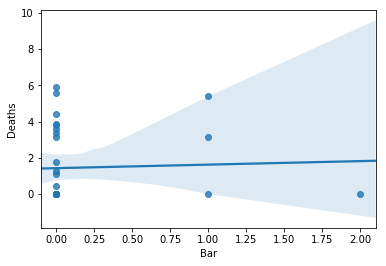

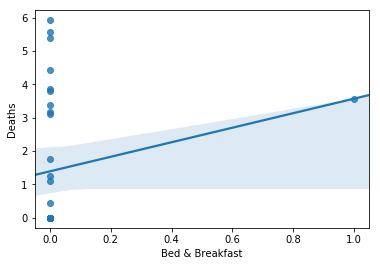

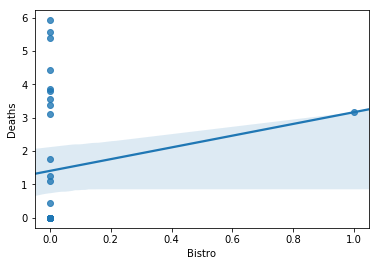

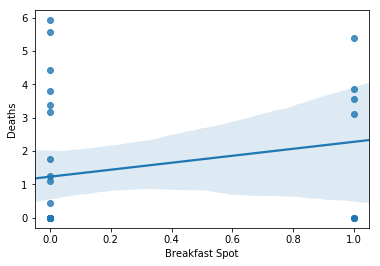

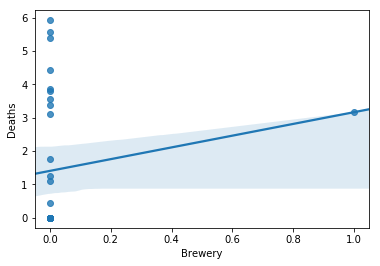

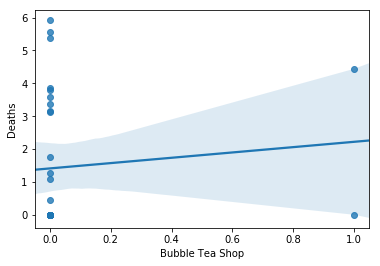

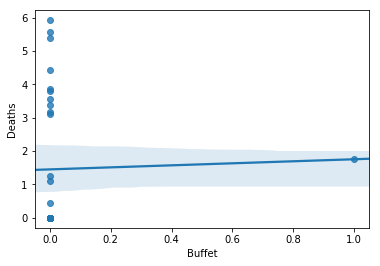

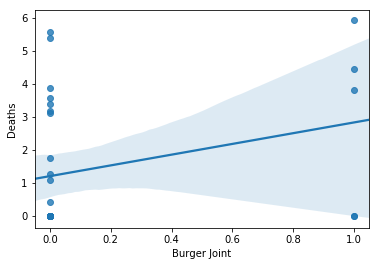

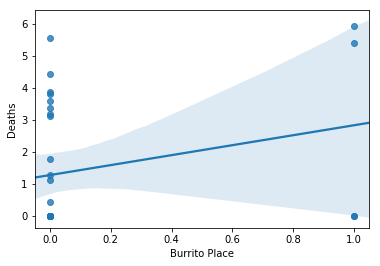

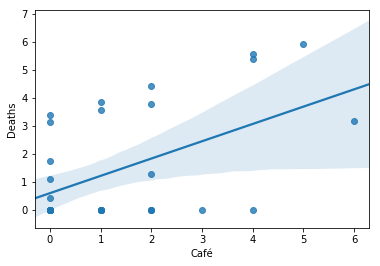

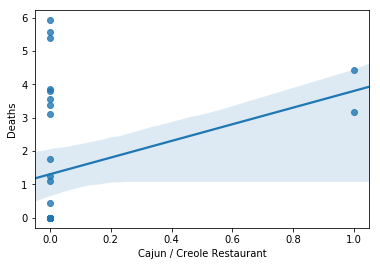

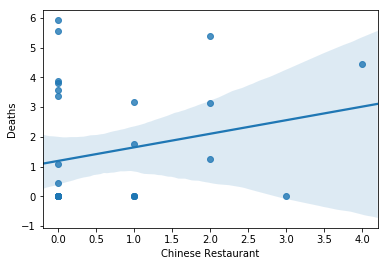

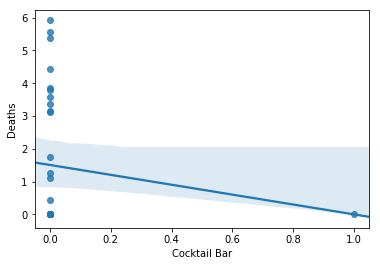

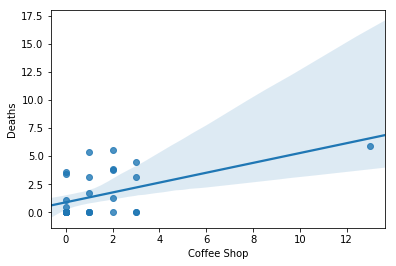

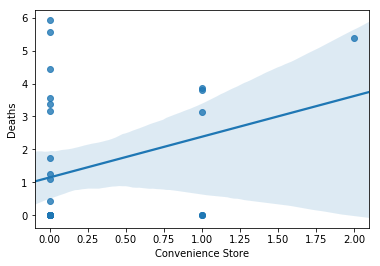

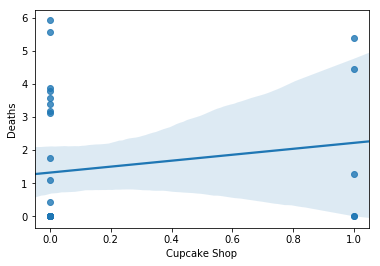

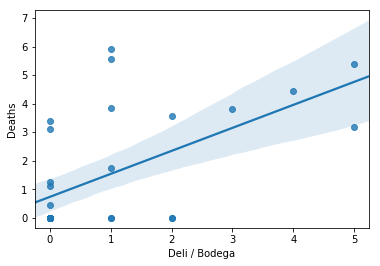

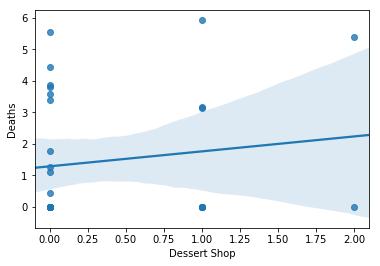

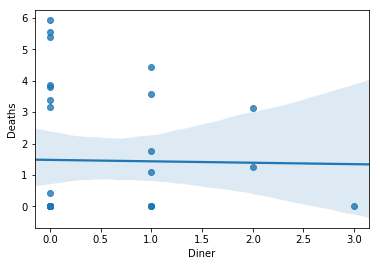

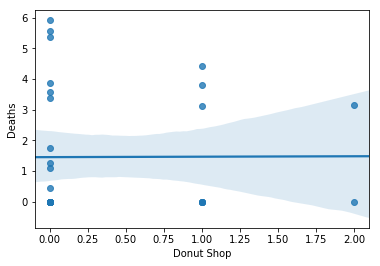

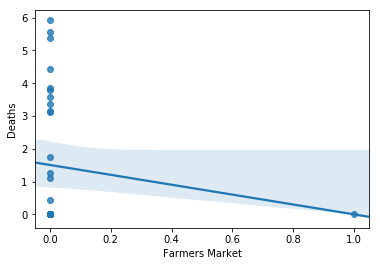

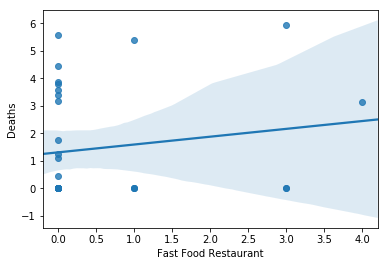

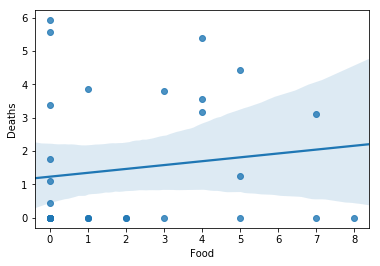

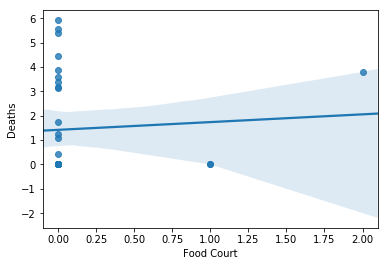

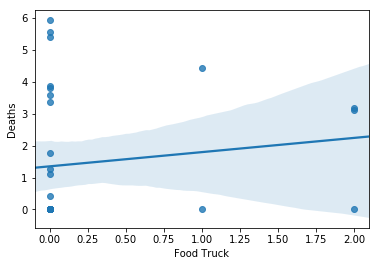

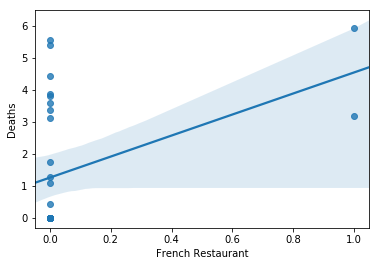

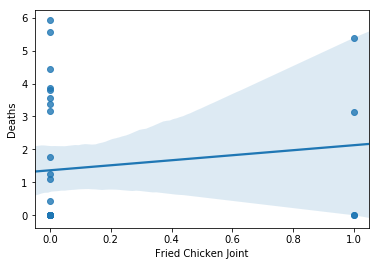

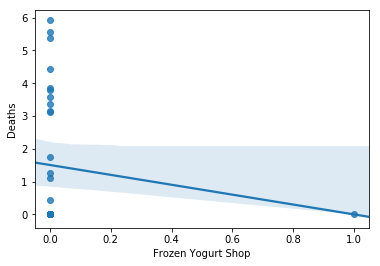

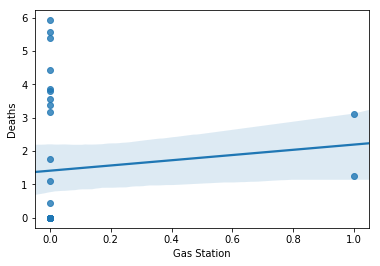

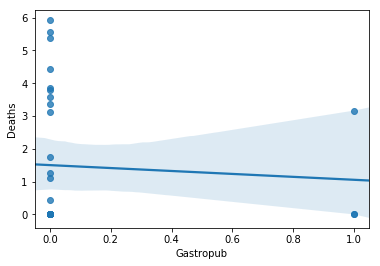

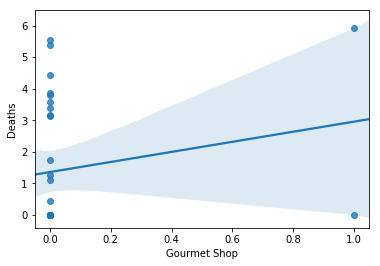

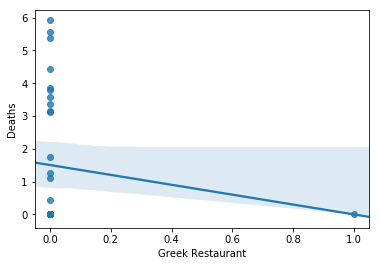

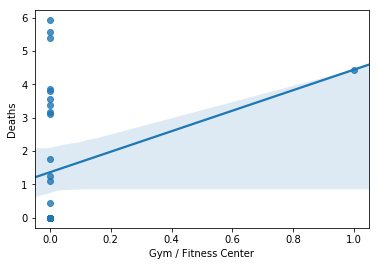

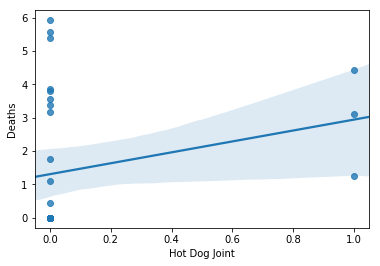

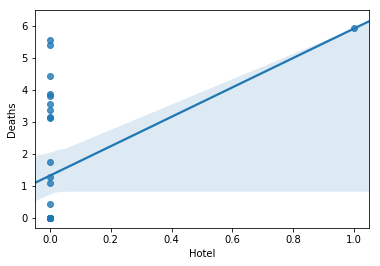

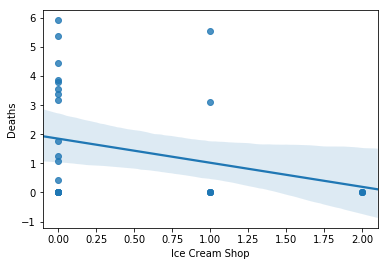

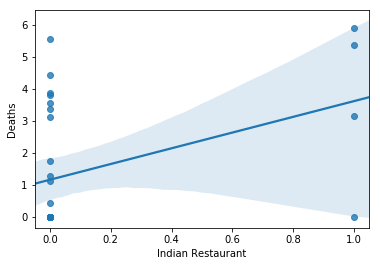

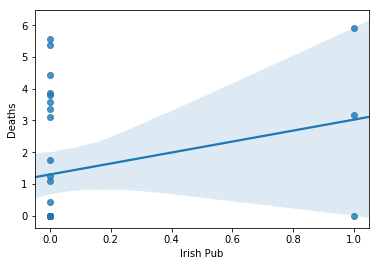

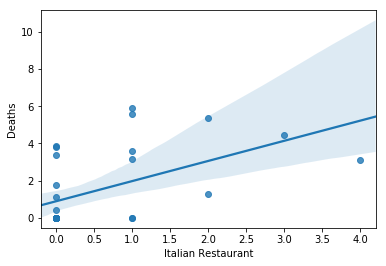

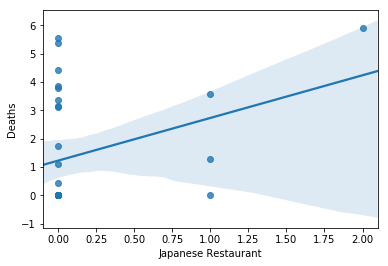

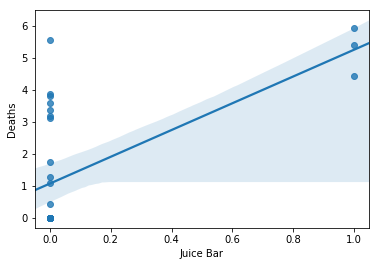

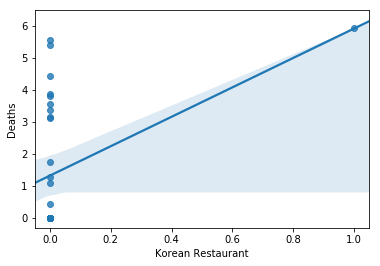

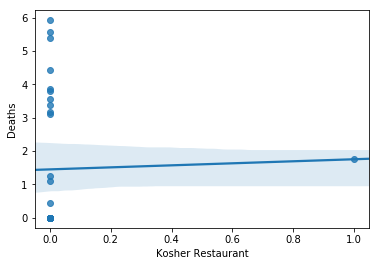

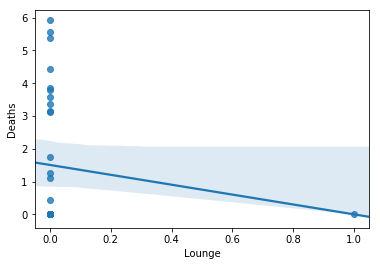

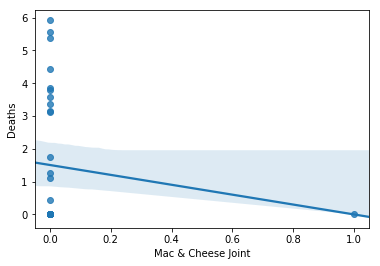

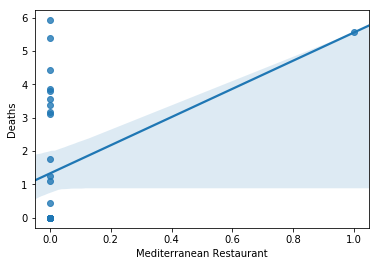

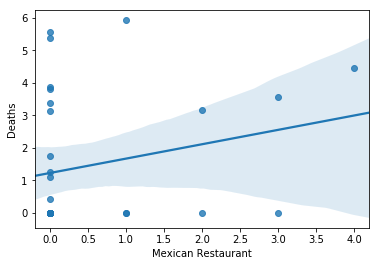

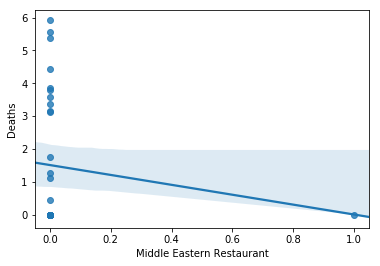

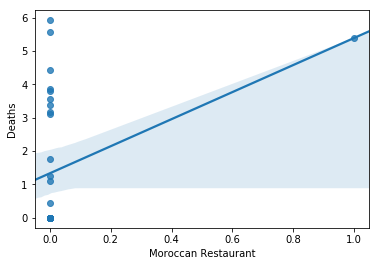

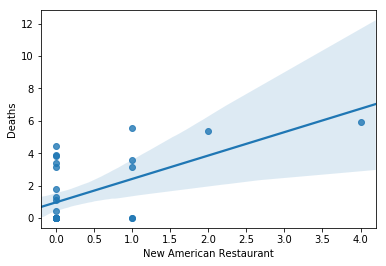

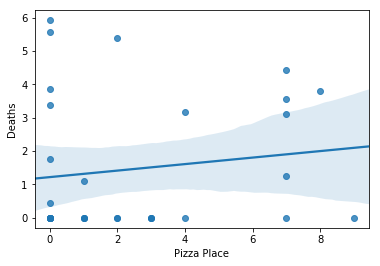

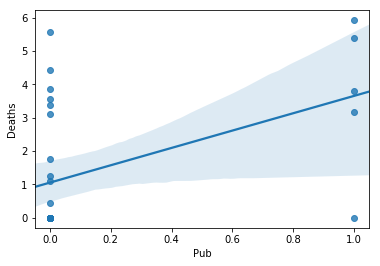

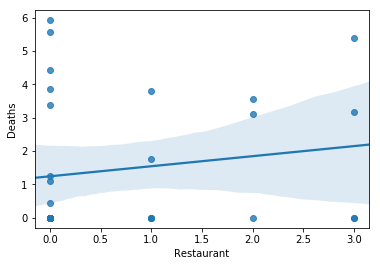

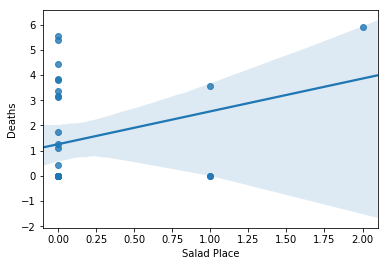

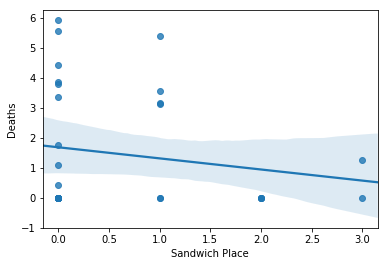

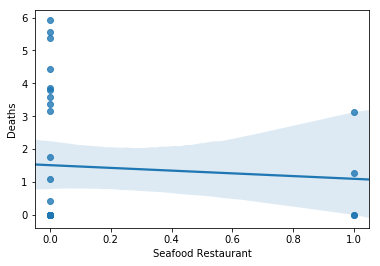

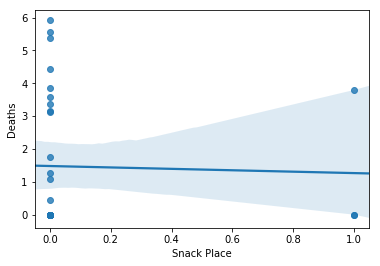

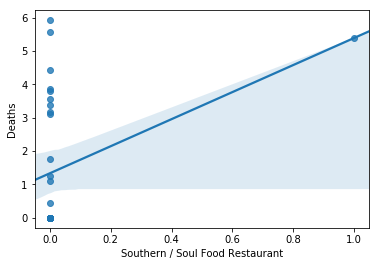

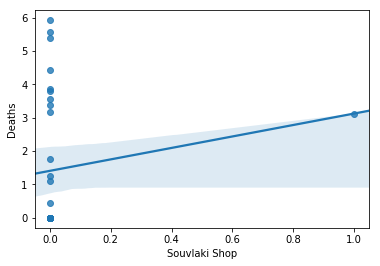

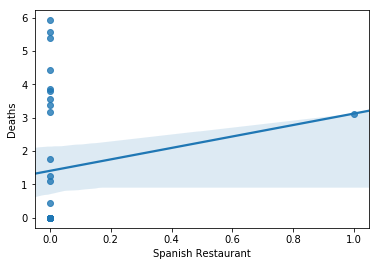

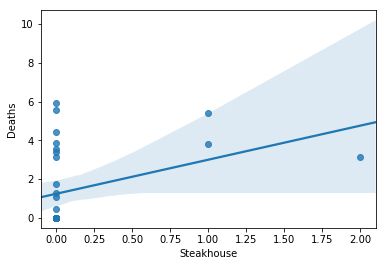

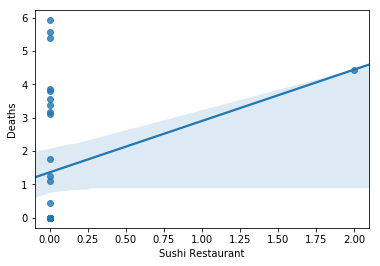

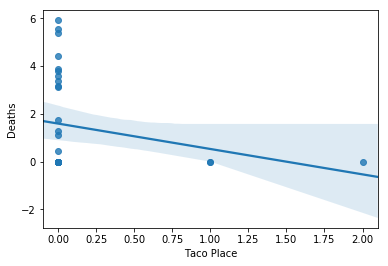

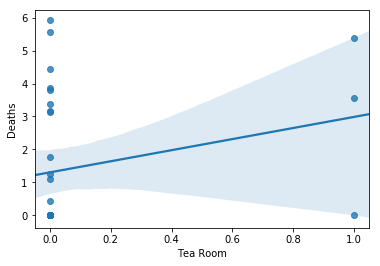

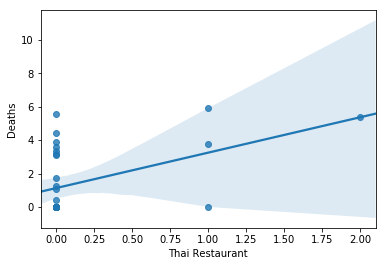

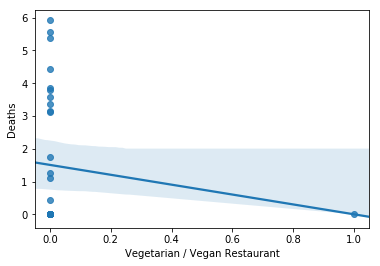

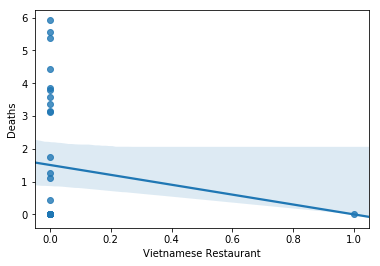

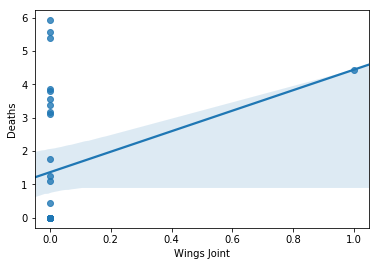

In [46]:
for i, col in enumerate(NY_Food_grouped.iloc[:,3:].columns):
    plt.figure(i)
    sns.regplot(x=col, y="Deaths", data=NY_Food_grouped)

__Visualizing scatter plots of number of different travel and night life venue categories with number of cases in each county:__

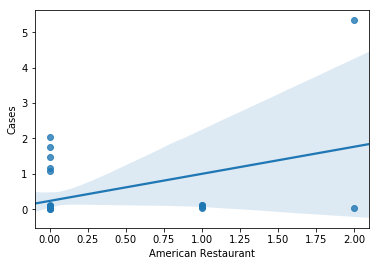

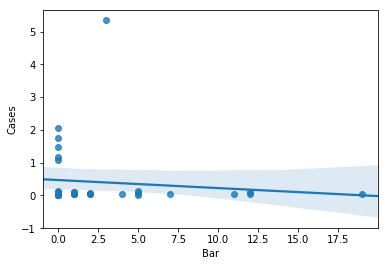

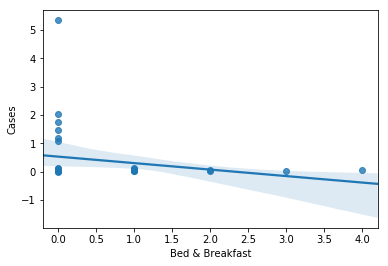

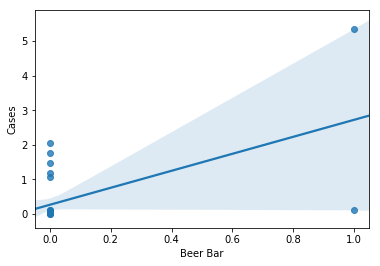

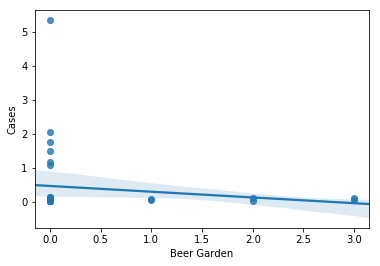

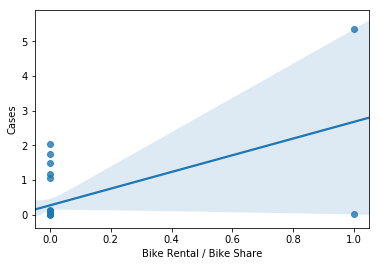

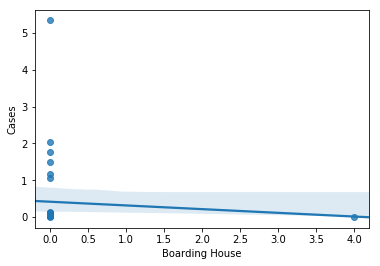

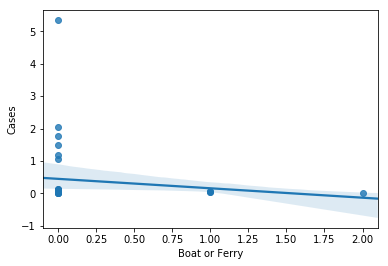

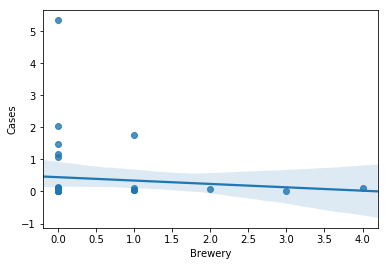

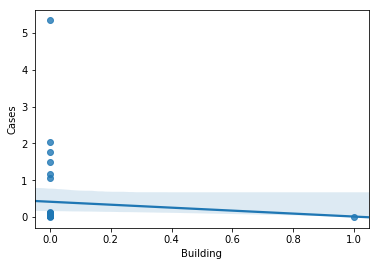

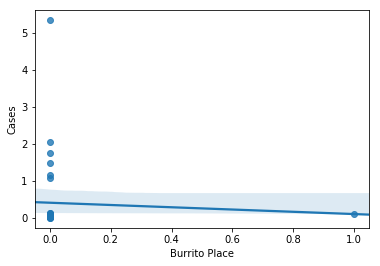

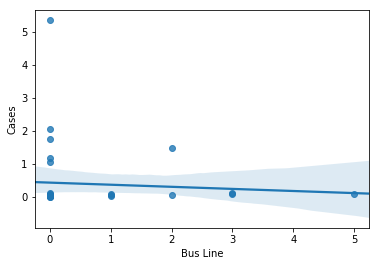

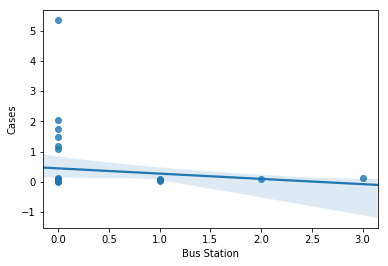

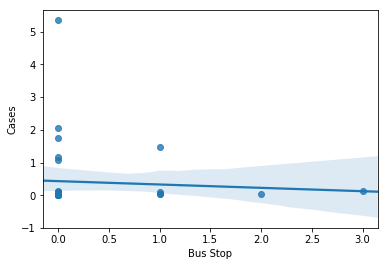

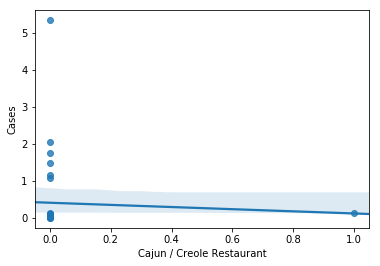

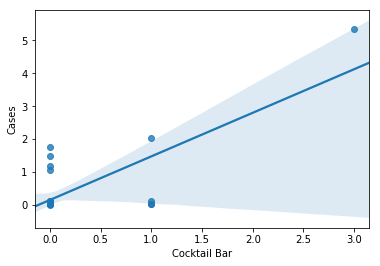

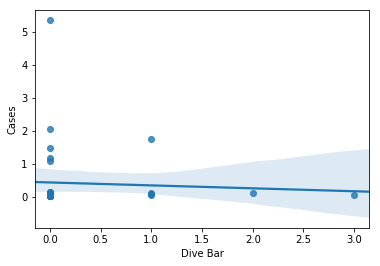

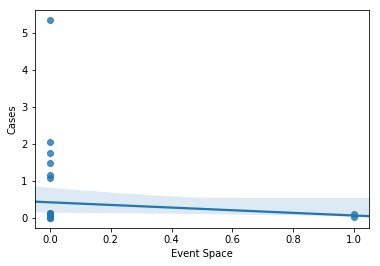

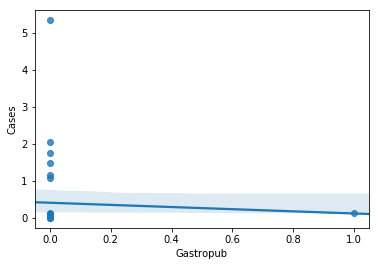

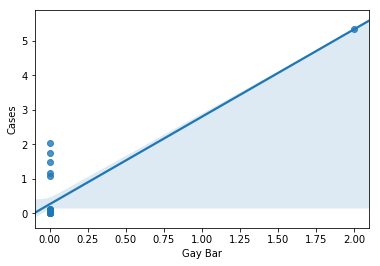

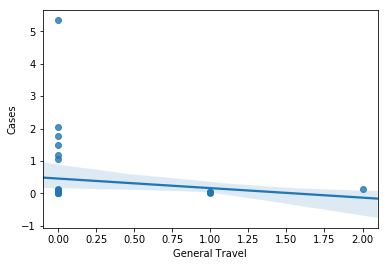

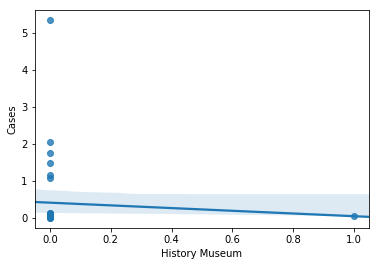

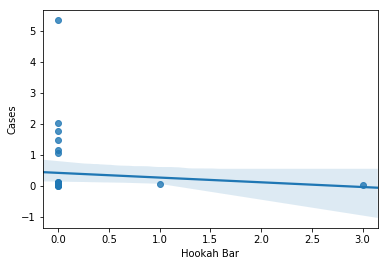

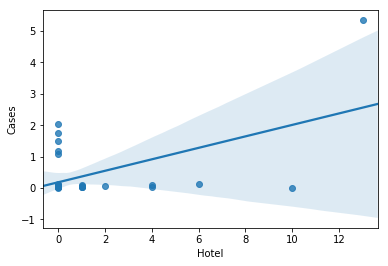

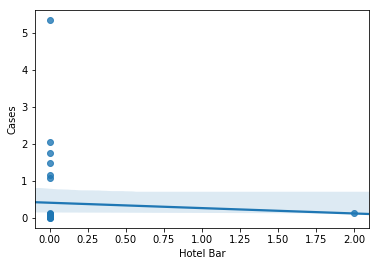

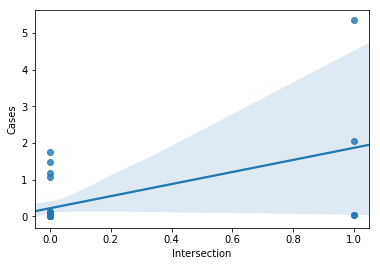

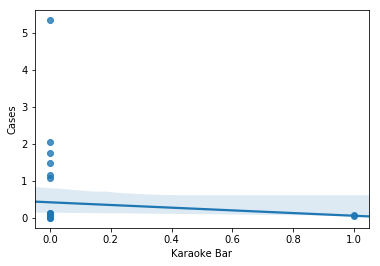

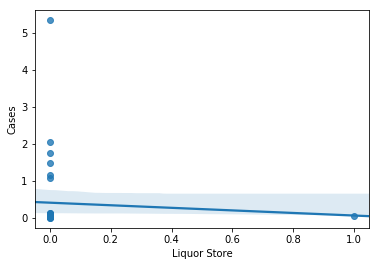

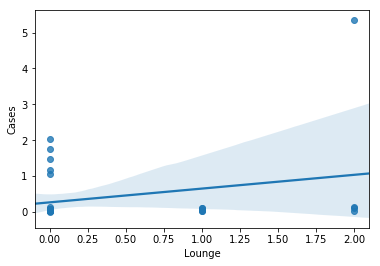

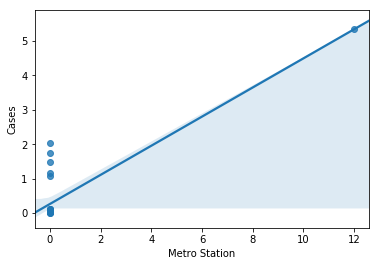

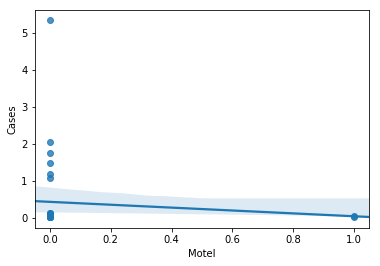

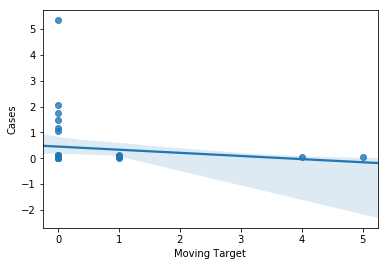

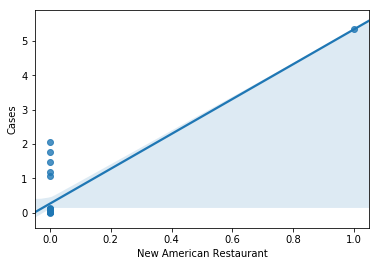

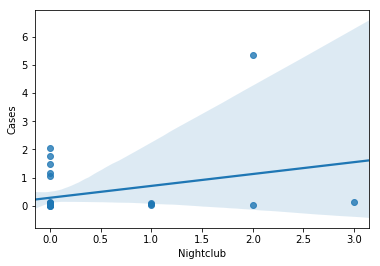

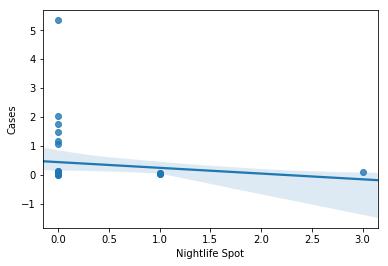

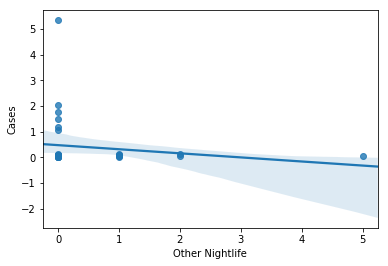

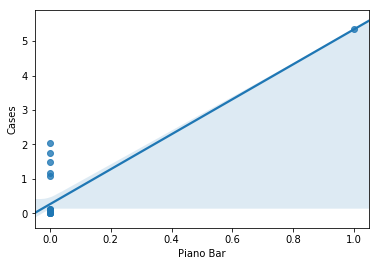

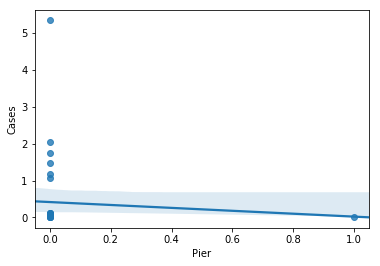

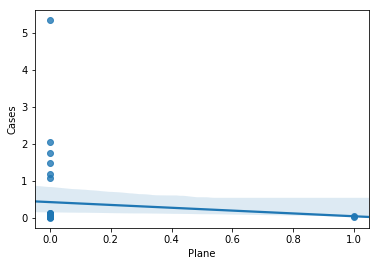

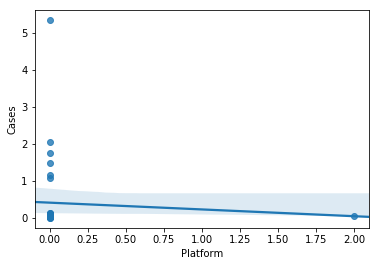

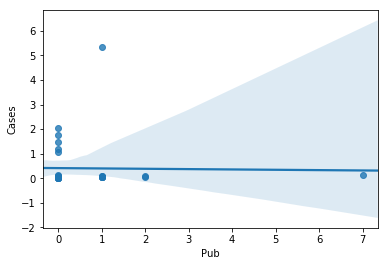

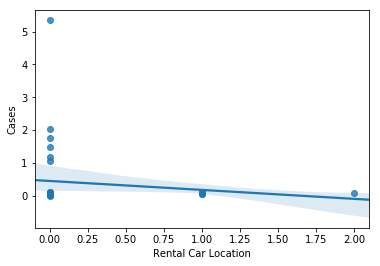

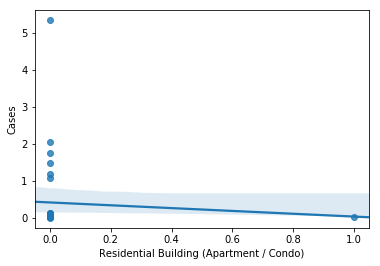

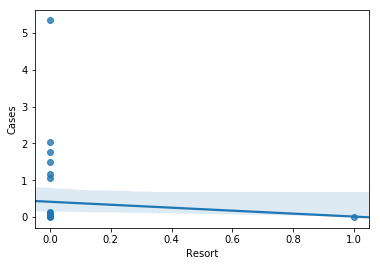

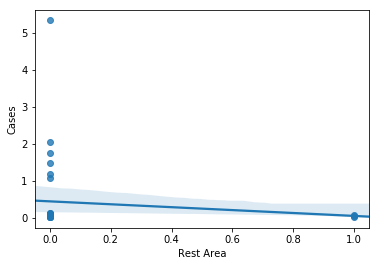

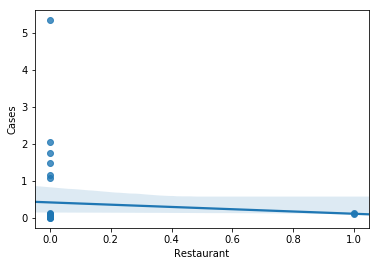

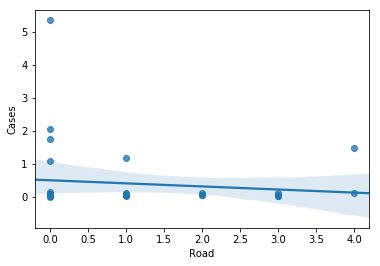

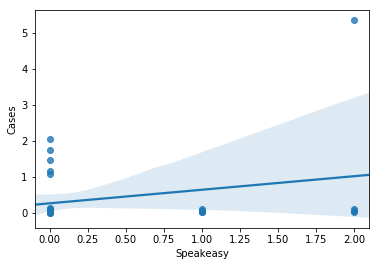

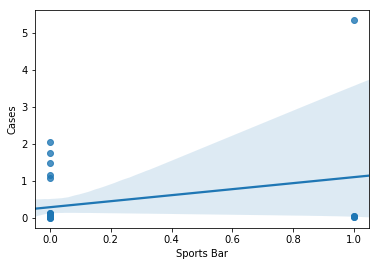

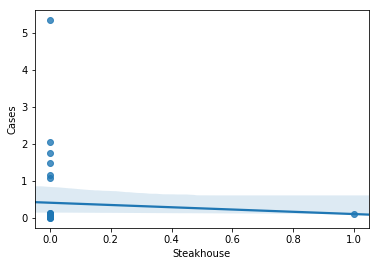

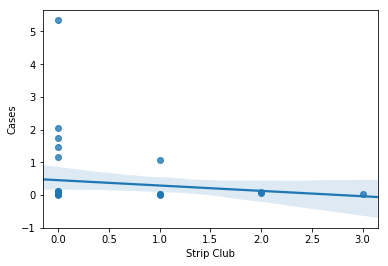

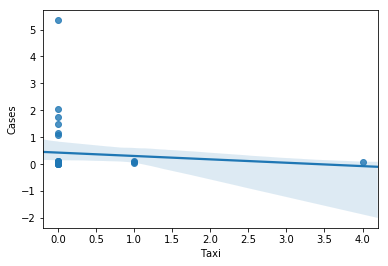

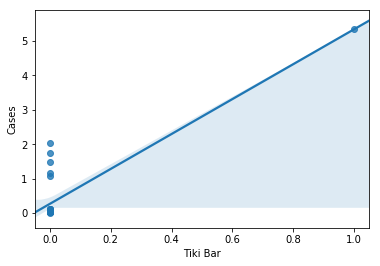

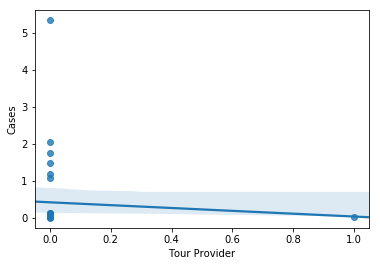

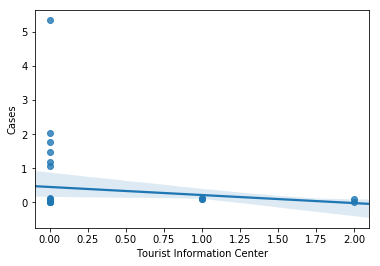

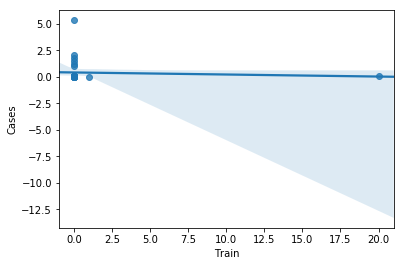

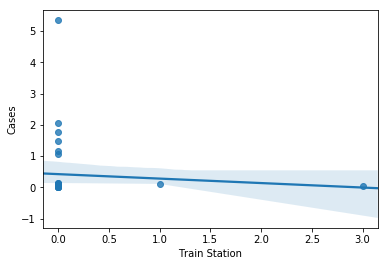

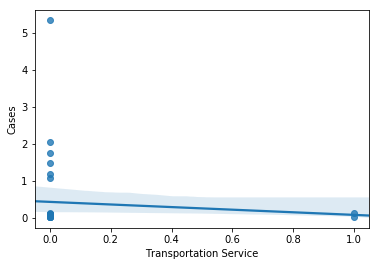

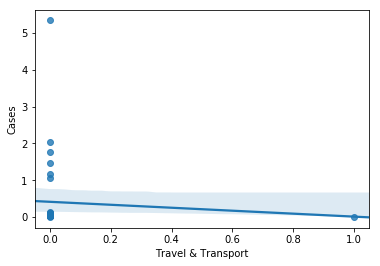

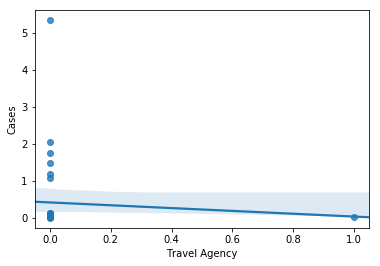

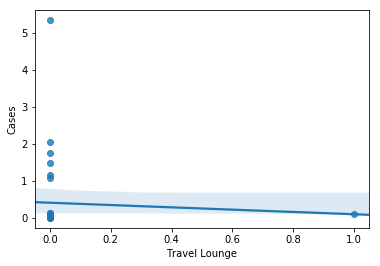

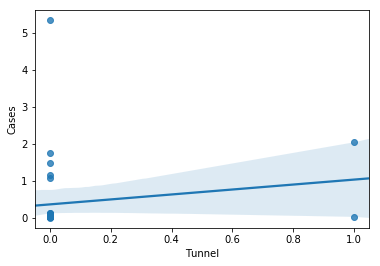

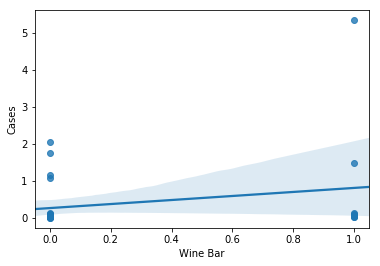

In [47]:
for i, col in enumerate(NY_TrvNL_grouped.iloc[:,3:].columns):
    plt.figure(i)
    sns.regplot(x=col, y="Cases", data=NY_TrvNL_grouped)

__Determining pearson coefficient and p-value for no. of food venue categories with no. of deaths__

In [49]:

for i, col in enumerate(NY_Food_grouped.iloc[:,3:].columns):
    pearson_coef, p_value = stats.pearsonr(NY_Food_grouped[col], NY_Food_grouped['Deaths'])
    print(col,":")
    print("Pearson Correlation Coefficient is", pearson_coef, "\nP-value of P =", p_value)

American Restaurant :
Pearson Correlation Coefficient is 0.27867318298128263 
P-value of P = 0.12247398443820566
Argentinian Restaurant :
Pearson Correlation Coefficient is -0.13241563753325059 
P-value of P = 0.4700210725733731
Asian Restaurant :
Pearson Correlation Coefficient is 0.24707264962371167 
P-value of P = 0.17279034176606997
BBQ Joint :
Pearson Correlation Coefficient is 0.054578956745121664 
P-value of P = 0.7667088048060274
Bagel Shop :
Pearson Correlation Coefficient is 0.31394499218660377 
P-value of P = 0.08014749089688783
Bakery :
Pearson Correlation Coefficient is 0.20217952351256796 
P-value of P = 0.2671259401441065
Bar :
Pearson Correlation Coefficient is 0.04321011808284643 
P-value of P = 0.8143501245685258
Bed & Breakfast :
Pearson Correlation Coefficient is 0.19122659523431063 
P-value of P = 0.2944465641944831
Bistro :
Pearson Correlation Coefficient is 0.1545072917804713 
P-value of P = 0.39848022354253754
Breakfast Spot :
Pearson Correlation Coefficient is 

__Determining pearson coefficient and p-value for no. of travel, nightlife venue categories with no. of deaths__

In [50]:

for i, col in enumerate(NY_TrvNL_grouped.iloc[:,3:].columns):
    pearson_coef, p_value = stats.pearsonr(NY_TrvNL_grouped[col], NY_TrvNL_grouped['Cases'])
    print(col,":")
    print("Pearson Correlation Coefficient is", pearson_coef, "\nP-value of P =", p_value)  

American Restaurant :
Pearson Correlation Coefficient is 0.4151059097774263 
P-value of P = 0.011819685666028723
Bar :
Pearson Correlation Coefficient is -0.10930146409944226 
P-value of P = 0.5257090177236555
Bed & Breakfast :
Pearson Correlation Coefficient is -0.2157262660902544 
P-value of P = 0.2063669114883813
Beer Bar :
Pearson Correlation Coefficient is 0.5725888383224378 
P-value of P = 0.00026299511632592933
Beer Garden :
Pearson Correlation Coefficient is -0.1407292085126491 
P-value of P = 0.41297948064238554
Bike Rental / Bike Share :
Pearson Correlation Coefficient is 0.5610594175326497 
P-value of P = 0.000371323335782046
Boarding House :
Pearson Correlation Coefficient is -0.0673160096941412 
P-value of P = 0.6964737983854882
Boat or Ferry :
Pearson Correlation Coefficient is -0.12389369679104144 
P-value of P = 0.4715813468007236
Brewery :
Pearson Correlation Coefficient is -0.09544772685250946 
P-value of P = 0.5797553552719515
Building :
Pearson Correlation Coefficie